20240908 整理自  https://weread.qq.com/web/reader/0403218071e8dae00406ed9kd1f32d7024fd1fe173d0651

源码库： https://github.com/davecom/ClassicComputerScienceProblemsInPython/tree/master/Chapter8

所谓双人、零和（zero-sum）​、全信息（perfect information）的对弈游戏，是指对弈双方均拥有关于游戏状态的所有信息，并且一方获得优势就意味着另一方失去优势。井字棋（tic-tac-toe）​、四子棋（Connect Four）​、跳棋和国际象棋都属于这类游戏。


### 棋盘游戏的基础组件

In [3]:
# board.py

from __future__ import annotations
from typing import NewType, List
from abc import ABC, abstractmethod

Move = NewType('Move', int)  # Move


class Piece: # 棋子
    @property
    def opposite(self) -> Piece:
        raise NotImplementedError("Should be implemented by subclasses.")


class Board(ABC):
    @property
    @abstractmethod
    def turn(self) -> Piece:  # 该轮到谁走棋了？
        ...

    @abstractmethod
    def move(self, location: Move) -> Board:  # 一步棋
        ...

    @property
    @abstractmethod
    def legal_moves(self) -> List[Move]: # 在当前位置上有哪些符合规则的走法？
        ...

    @property
    @abstractmethod
    def is_win(self) -> bool: # 游戏有人赢了吗？
        ...

    @property
    def is_draw(self) -> bool: # 游戏平局了吗？等效于 (没人赢 + 没有符合规则的棋步可走)
        return (not self.is_win) and (len(self.legal_moves) == 0)

    @abstractmethod
    def evaluate(self, player: Piece) -> float: # 评估当前位置，看看哪位玩家占据了优势。
        ...

### 8.2 井字棋

井字棋的棋子可以是 X、O 或空（在枚举中用 E 表示）​。

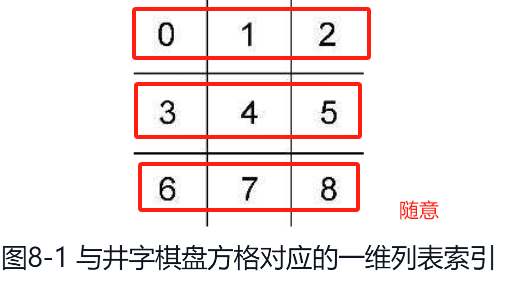

In [11]:
# tictactoe.py

from __future__ import annotations
from typing import List
from enum import Enum
# from board import Piece, Board, Move


class TTTPiece(Piece, Enum):
    X = "X"
    O = "O"
    E = " " # stand-in for empty

    @property
    def opposite(self) -> TTTPiece: # 当走完一步棋之后，就要从一个玩家的回合翻转到另一个玩家的回合
        if self == TTTPiece.X:
            return TTTPiece.O
        elif self == TTTPiece.O:
            return TTTPiece.X
        else:
            return TTTPiece.E

    def __str__(self) -> str:
        return self.value

## 棋盘状态
class TTTBoard(Board):
    def __init__(self, position: List[TTTPiece] = [TTTPiece.E] * 9, turn: TTTPiece = TTTPiece.X) -> None:
        self.position: List[TTTPiece] = position
        self._turn: TTTPiece = turn # 确保所有 Board 的子类都能记录当前轮到哪个玩家了。

    @property
    def turn(self) -> Piece:
        return self._turn

    def move(self, location: Move) -> Board:
        temp_position: List[TTTPiece] = self.position.copy()
        temp_position[location] = self._turn
        return TTTBoard(temp_position, self._turn.opposite)

    @property
    def legal_moves(self) -> List[Move]: # 空格均可落子
        return [Move(l) for l in range(len(self.position)) if self.position[l] == TTTPiece.E]

    @property
    def is_win(self) -> bool: # 共 8 种 赢的情形  3 + 3 + 2
        # three row, three column, and then two diagonal checks
        return self.position[0] == self.position[1] and self.position[0] == self.position[2] and self.position[0] != TTTPiece.E or \
        self.position[3] == self.position[4] and self.position[3] == self.position[5] and self.position[3] != TTTPiece.E or \
        self.position[6] == self.position[7] and self.position[6] == self.position[8] and self.position[6] != TTTPiece.E or \
        self.position[0] == self.position[3] and self.position[0] == self.position[6] and self.position[0] != TTTPiece.E or \
        self.position[1] == self.position[4] and self.position[1] == self.position[7] and self.position[1] != TTTPiece.E or \
        self.position[2] == self.position[5] and self.position[2] == self.position[8] and self.position[2] != TTTPiece.E or \
        self.position[0] == self.position[4] and self.position[0] == self.position[8] and self.position[0] != TTTPiece.E or \
        self.position[2] == self.position[4] and self.position[2] == self.position[6] and self.position[2] != TTTPiece.E

    def evaluate(self, player: Piece) -> float:  # 判断输赢
        if self.is_win and self.turn == player:
            return -1
        elif self.is_win and self.turn != player:
            return 1
        else:
            return 0

    def __repr__(self) -> str: # 打印棋局
        return f"""{self.position[0]}|{self.position[1]}|{self.position[2]}
-----
{self.position[3]}|{self.position[4]}|{self.position[5]}
-----
{self.position[6]}|{self.position[7]}|{self.position[8]}"""

### 8.2.2 极小化极大算法

In [5]:
# minimax.py

from __future__ import annotations
# from board import Piece, Board, Move


# Find the best possible outcome for original player
def minimax(board: Board, maximizing: bool, original_player: Piece, max_depth: int = 8) -> float:
    # Base case – terminal position or maximum depth reached
    if board.is_win or board.is_draw or max_depth == 0:
        return board.evaluate(original_player)

    # Recursive case - maximize your gains or minimize the opponent's gains
    if maximizing:
        best_eval: float = float("-inf") # arbitrarily low starting point
        for move in board.legal_moves:
            result: float = minimax(board.move(move), False, original_player, max_depth - 1)
            best_eval = max(result, best_eval) # we want the move with the highest evaluation
        return best_eval
    else: # minimizing
        worst_eval: float = float("inf")
        for move in board.legal_moves:
            result = minimax(board.move(move), True, original_player, max_depth - 1)
            worst_eval = min(result, worst_eval) # we want the move with the lowest evaluation
        return worst_eval


def alphabeta(board: Board, maximizing: bool, original_player: Piece, max_depth: int = 8, alpha: float = float("-inf"), beta: float = float("inf")) -> float:
    # Base case – terminal position or maximum depth reached
    if board.is_win or board.is_draw or max_depth == 0: # 递归跳出条件： 达到终局状态 或 最大深度
        return board.evaluate(original_player)

    # Recursive case - maximize your gains or minimize the opponent's gains
    if maximizing:
        for move in board.legal_moves:
            result: float = alphabeta(board.move(move), False, original_player, max_depth - 1, alpha, beta)
            alpha = max(result, alpha)
            if beta <= alpha:
                break
        return alpha
    else:  # minimizing
        for move in board.legal_moves:
            result = alphabeta(board.move(move), True, original_player, max_depth - 1, alpha, beta)
            beta = min(result, beta)
            if beta <= alpha:
                break
        return beta


# 为某棋局中每一步合法的走法循环调用 minimax(),找出评分最高的走法
# Find the best possible move in the current position
# looking up to max_depth ahead
def find_best_move(board: Board, max_depth: int = 8) -> Move:
    best_eval: float = float("-inf")
    best_move: Move = Move(-1)
    for move in board.legal_moves:
        result: float = alphabeta(board.move(move), False, board.turn, max_depth)  # 这里默认是 alphabeta， 若考虑用 minmax 方法 修改即可
        if result > best_eval:
            best_eval = result
            best_move = move
    return best_move


### 8.2.3 用井字棋测试极小化极大算法


学习极小化极大算法存在一个常见错误，即采用可修改的数据结构，这种数据结构在极小化极大算法的递归调用过程中会被改动，因此**无法回到原始状态进行再次调用**。

为 3 种不同的井字棋局查找下一步的正确走法。

In [9]:
# tictactoe_tests.py

import unittest  # 测试模块
from typing import List
# from minimax import find_best_move
# from tictactoe import TTTPiece, TTTBoard
# from board import Move


class TTTMinimaxTestCase(unittest.TestCase):
    def test_easy_position(self):
        # win in 1 move
        to_win_easy_position: List[TTTPiece] = [TTTPiece.X, TTTPiece.O, TTTPiece.X,
                                                TTTPiece.X, TTTPiece.E, TTTPiece.O,
                                                TTTPiece.E, TTTPiece.E, TTTPiece.O]
        test_board1: TTTBoard = TTTBoard(to_win_easy_position, TTTPiece.X)
        answer1: Move = find_best_move(test_board1)
        self.assertEqual(answer1, 6)

    def test_block_position(self):
        # must block O's win
        to_block_position: List[TTTPiece] = [TTTPiece.X, TTTPiece.E, TTTPiece.E,
                                             TTTPiece.E, TTTPiece.E, TTTPiece.O,
                                             TTTPiece.E, TTTPiece.X, TTTPiece.O]
        test_board2: TTTBoard = TTTBoard(to_block_position, TTTPiece.X)
        answer2: Move = find_best_move(test_board2)
        self.assertEqual(answer2, 2)

    def test_hard_position(self):
        # find the best move to win 2 moves
        to_win_hard_position: List[TTTPiece] = [TTTPiece.X, TTTPiece.E, TTTPiece.E,
                                                TTTPiece.E, TTTPiece.E, TTTPiece.O,
                                                TTTPiece.O, TTTPiece.X, TTTPiece.E]
        test_board3: TTTBoard = TTTBoard(to_win_hard_position, TTTPiece.X)
        answer3: Move = find_best_move(test_board3)
        self.assertEqual(answer3, 1)


if '<module>' == '__main__':  # 解释器。。 本地用 if __name__ == '__main__':
    unittest.main()


### 8.2.4 开发井字棋 AI

对两个棋手下棋形成的棋局进行评分。


完美的井字棋结果就是平局。

有鉴于此，井字棋 AI 应该是不可战胜的。如果人类竭尽全力，最多也就是平局。如果人类走错一步，AI 就会赢棋。


<font color=blue>输入你要下的位置的编号 ！！！</font>

012

345

678

In [16]:
# tictactoe_ai.py

# from minimax import find_best_move
# from tictactoe import TTTBoard
# from board import Move, Board

board: Board = TTTBoard()


def get_player_move() -> Move:
    player_move: Move = Move(-1)
    while player_move not in board.legal_moves:
        play: int = int(input("Enter a legal square (0-8):"))
        player_move = Move(play)
    return player_move


if __name__ == "__main__":
    # main game loop
    while True:
        human_move: Move = get_player_move()
        board = board.move(human_move)
        if board.is_win:
            print("Human wins!")
            break
        elif board.is_draw:
            print("Draw!")
            break
        computer_move: Move = find_best_move(board)
        print(f"Computer move is {computer_move}")
        board = board.move(computer_move)
        print(board)
        if board.is_win:
            print("Computer wins!")
            break
        elif board.is_draw:
            print("Draw!")
            break

Enter a legal square (0-8):0
Computer move is 4
X| | 
-----
 |O| 
-----
 | | 
Enter a legal square (0-8):1
Computer move is 2
X|X|O
-----
 |O| 
-----
 | | 
Enter a legal square (0-8):6
Computer move is 3
X|X|O
-----
O|O| 
-----
X| | 
Enter a legal square (0-8):5
Computer move is 7
X|X|O
-----
O|O|X
-----
X|O| 
Enter a legal square (0-8):8
Draw!
